# Devices Price Classification System

### Import Libraries

In [380]:
# Import Libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.pipeline import Pipeline
import numpy as np
import plotly.subplots as sp
import plotly.graph_objects as go
import joblib
from sklearn.calibration import label_binarize
from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import precision_recall_curve

In [381]:
layout_options = {
    'paper_bgcolor':"#383838",
    'plot_bgcolor':'#383838',
    'title_font': dict(color='white'),
    'legend_font': dict(color='white'),
    'yaxis':dict(color="white"),
    'xaxis':dict(color="white")
    }

### Load the dataset

In [382]:
df = pd.read_csv('train.csv') 
df.head()

,battery_power,blue,clock_speed,dual_sim,fc,four_g,int_memory,m_dep,mobile_wt,n_cores,...,px_height,px_width,ram,sc_h,sc_w,talk_time,three_g,touch_screen,wifi,price_range
0,842,0,2.2,0,1.0,0.0,7.0,0.6,188.0,2.0,...,20.0,756.0,2549.0,9.0,7.0,19,0,0,1,1
1,1021,1,0.5,1,0.0,1.0,53.0,0.7,136.0,3.0,...,905.0,1988.0,2631.0,17.0,3.0,7,1,1,0,2
2,563,1,0.5,1,2.0,1.0,41.0,0.9,145.0,5.0,...,1263.0,1716.0,2603.0,11.0,2.0,9,1,1,0,2
3,615,1,2.5,0,0.0,0.0,10.0,0.8,131.0,6.0,...,1216.0,1786.0,2769.0,16.0,8.0,11,1,0,0,2
4,1821,1,1.2,0,13.0,1.0,44.0,0.6,141.0,2.0,...,1208.0,1212.0,1411.0,8.0,2.0,15,1,1,0,1


## Preproccessing

Display the summary statistics of the dataset

In [383]:
styled = df.describe().style.set_table_styles([
    {'selector': 'th', 'props': [('background', '#606060'), 
                                 ('color', 'white'), 
                                 ('font-family', 'verdana')]},
    {'selector': 'td', 'props': [('font-family', 'verdana')]},
])

styled

,battery_power,blue,clock_speed,dual_sim,fc,four_g,int_memory,m_dep,mobile_wt,n_cores,pc,px_height,px_width,ram,sc_h,sc_w,talk_time,three_g,touch_screen,wifi,price_range
count,2000.000000,2000.000000,2000.000000,2000.000000,1995.000000,1995.000000,1995.000000,1995.000000,1996.000000,1996.000000,1995.000000,1996.000000,1998.000000,1998.000000,1999.000000,1999.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000
mean,1238.518500,0.495000,1.522250,0.509500,4.310276,0.521303,32.048120,0.502256,140.266533,4.518036,9.915789,644.651804,1251.287788,2124.262262,12.303652,5.766383,11.011000,0.761500,0.503000,0.507000,1.500000
std,439.418206,0.500100,0.816004,0.500035,4.335766,0.499671,18.146476,0.288530,35.384676,2.288946,6.058469,443.355443,432.352930,1085.273372,4.212373,4.357400,5.463955,0.426273,0.500116,0.500076,1.118314
min,501.000000,0.000000,0.500000,0.000000,0.000000,0.000000,2.000000,0.100000,80.000000,1.000000,0.000000,0.000000,500.000000,256.000000,5.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000
25%,851.750000,0.000000,0.700000,0.000000,1.000000,0.000000,16.000000,0.200000,109.000000,3.000000,5.000000,282.000000,874.250000,1206.500000,9.000000,2.000000,6.000000,1.000000,0.000000,0.000000,0.750000
50%,1226.000000,0.000000,1.500000,1.000000,3.000000,1.000000,32.000000,0.500000,141.000000,4.000000,10.000000,564.000000,1247.000000,2147.500000,12.000000,5.000000,11.000000,1.000000,1.000000,1.000000,1.500000
75%,1615.250000,1.000000,2.200000,1.000000,7.000000,1.000000,48.000000,0.800000,170.000000,7.000000,15.000000,947.250000,1633.000000,3065.500000,16.000000,9.000000,16.000000,1.000000,1.000000,1.000000,2.250000
max,1998.000000,1.000000,3.000000,1.000000,19.000000,1.000000,64.000000,1.000000,200.000000,8.000000,20.000000,1960.000000,1998.000000,3998.000000,19.000000,18.000000,20.000000,1.000000,1.000000,1.000000,3.000000


In [384]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   battery_power  2000 non-null   int64  
 1   blue           2000 non-null   int64  
 2   clock_speed    2000 non-null   float64
 3   dual_sim       2000 non-null   int64  
 4   fc             1995 non-null   float64
 5   four_g         1995 non-null   float64
 6   int_memory     1995 non-null   float64
 7   m_dep          1995 non-null   float64
 8   mobile_wt      1996 non-null   float64
 9   n_cores        1996 non-null   float64
 10  pc             1995 non-null   float64
 11  px_height      1996 non-null   float64
 12  px_width       1998 non-null   float64
 13  ram            1998 non-null   float64
 14  sc_h           1999 non-null   float64
 15  sc_w           1999 non-null   float64
 16  talk_time      2000 non-null   int64  
 17  three_g        2000 non-null   int64  
 18  touch_sc

We notice that there is a missing values in some columns 

#### Remove missing values 
since the missing values is not too much we can remove all tansaction that contains it, otherwise we could use Imputation (`SimpleImputer` or `IterativeImputer`) for filling missing values

In [385]:
# Drop record of missing values
df.dropna(inplace=True)

# Check for missing values
print(df.isnull().sum())

battery_power    0
blue             0
clock_speed      0
dual_sim         0
fc               0
four_g           0
int_memory       0
m_dep            0
mobile_wt        0
n_cores          0
pc               0
px_height        0
px_width         0
ram              0
sc_h             0
sc_w             0
talk_time        0
three_g          0
touch_screen     0
wifi             0
price_range      0
dtype: int64


Distinguish columns

In [386]:
# Define a list of binary columns
binary_columns = ['blue', 'dual_sim', 'four_g', 'three_g', 'touch_screen', 'wifi']

# Get the rest of the columns
non_binary_columns = list(set(df.columns) - set(binary_columns))
non_binary_columns

['sc_h',
 'mobile_wt',
 'talk_time',
 'px_height',
 'pc',
 'sc_w',
 'int_memory',
 'px_width',
 'm_dep',
 'battery_power',
 'price_range',
 'ram',
 'clock_speed',
 'n_cores',
 'fc']

### Filter out Illogical values

In [387]:
# Handle illogical values in binary columns
for column in binary_columns:
    df[column] = df[column].apply(lambda x: 1 if x >= 0.5 else 0)

# Check if there are any illogical values left
for column in binary_columns:
    if df[column].nunique() > 2:
        print(f"Column {column} contains illogical values.")
    else:
        print(f"Column {column} is clean.")
        
# Define the valid values for 'price_range'
valid_price_range_values = [0, 1, 2, 3]

# Remove rows with illogical 'price_range' values
df = df[df['price_range'].isin(valid_price_range_values)]

# Check if there are any illogical values left in the 'price_range' column
if df['price_range'].nunique() > 4:
    print("Column 'price_range' still contains illogical values.")
else:
    print("Column 'price_range' is now clean.")

Column blue is clean.
Column dual_sim is clean.
Column four_g is clean.
Column three_g is clean.
Column touch_screen is clean.
Column wifi is clean.
Column 'price_range' is now clean.


In [388]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1991 entries, 0 to 1999
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   battery_power  1991 non-null   int64  
 1   blue           1991 non-null   int64  
 2   clock_speed    1991 non-null   float64
 3   dual_sim       1991 non-null   int64  
 4   fc             1991 non-null   float64
 5   four_g         1991 non-null   int64  
 6   int_memory     1991 non-null   float64
 7   m_dep          1991 non-null   float64
 8   mobile_wt      1991 non-null   float64
 9   n_cores        1991 non-null   float64
 10  pc             1991 non-null   float64
 11  px_height      1991 non-null   float64
 12  px_width       1991 non-null   float64
 13  ram            1991 non-null   float64
 14  sc_h           1991 non-null   float64
 15  sc_w           1991 non-null   float64
 16  talk_time      1991 non-null   int64  
 17  three_g        1991 non-null   int64  
 18  touch_screen 

### Create a box plot for each column</br>
In order to detect outliers

In [389]:
# Create subplots with two columns
fig = sp.make_subplots(rows=len(non_binary_columns) // 2 + len(non_binary_columns) % 2, cols=2, vertical_spacing=0.03)


# Add box plots to the subplots
for i, column in enumerate(non_binary_columns, start=1):
    fig.add_trace(go.Box(y=df[column], name=column), row=(i-1)//2 + 1, col=(i-1)%2 + 1)

# Adjust the layout
fig.update_layout( **layout_options, height=150*len(non_binary_columns), width=950)

# Change the color of subplot titles to white
for annotation in fig['layout']['annotations']: 
    annotation['font'] = dict(color='white')
    
# Change the color of axis titles and tick labels to white
for axis in fig.layout:
    if type(fig.layout[axis]) == go.layout.XAxis:
        fig.layout[axis].title.font.color = 'white'
        fig.layout[axis].tickfont.color = 'white'
    elif type(fig.layout[axis]) == go.layout.YAxis:
        fig.layout[axis].title.font.color = 'white'
        fig.layout[axis].tickfont.color = 'white'

# Show the plot
fig.show()

We notice that the `fc` and `px_height` has outliers values 

In [390]:
# Define the columns that you want to check for outliers
outlier_columns = ['fc', 'px_height']

# Handle outliers in the 'fc' and 'px_height' columns
for column in outlier_columns:
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1

    # Define the acceptable range
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Identify the outliers
    outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)]

    # Remove the outliers
    df = df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

# Check the cleaned dataset
styled = df.describe().style.set_table_styles([
    {'selector': 'th', 'props': [('background', '#606060'), 
                                 ('color', 'white'), 
                                 ('font-family', 'verdana')]},
    {'selector': 'td', 'props': [('font-family', 'verdana')]},
])

styled

,battery_power,blue,clock_speed,dual_sim,fc,four_g,int_memory,m_dep,mobile_wt,n_cores,pc,px_height,px_width,ram,sc_h,sc_w,talk_time,three_g,touch_screen,wifi,price_range
count,1971.000000,1971.000000,1971.000000,1971.000000,1971.000000,1971.000000,1971.000000,1971.000000,1971.000000,1971.000000,1971.000000,1971.000000,1971.000000,1971.000000,1971.000000,1971.000000,1971.000000,1971.000000,1971.000000,1971.000000,1971.000000
mean,1236.142060,0.495687,1.521360,0.510401,4.187722,0.520041,32.083206,0.502486,140.182141,4.523085,9.828513,640.855403,1249.233891,2124.554033,12.318113,5.781329,10.993912,0.760020,0.500254,0.503298,1.497210
std,439.793250,0.500108,0.816732,0.500019,4.165762,0.499725,18.119098,0.288931,35.384083,2.294741,6.019766,439.092009,431.324515,1084.879224,4.209100,4.359059,5.458934,0.427179,0.500127,0.500116,1.118087
min,501.000000,0.000000,0.500000,0.000000,0.000000,0.000000,2.000000,0.100000,80.000000,1.000000,0.000000,0.000000,500.000000,256.000000,5.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000
25%,849.000000,0.000000,0.700000,0.000000,1.000000,0.000000,16.000000,0.200000,109.000000,3.000000,5.000000,281.500000,874.000000,1209.500000,9.000000,2.000000,6.000000,1.000000,0.000000,0.000000,0.000000
50%,1221.000000,0.000000,1.500000,1.000000,3.000000,1.000000,32.000000,0.500000,141.000000,4.000000,10.000000,562.000000,1247.000000,2147.000000,12.000000,5.000000,11.000000,1.000000,1.000000,1.000000,1.000000
75%,1614.000000,1.000000,2.200000,1.000000,7.000000,1.000000,48.000000,0.800000,170.000000,7.000000,15.000000,942.000000,1629.500000,3067.000000,16.000000,9.000000,16.000000,1.000000,1.000000,1.000000,2.000000
max,1998.000000,1.000000,3.000000,1.000000,16.000000,1.000000,64.000000,1.000000,200.000000,8.000000,20.000000,1920.000000,1998.000000,3998.000000,19.000000,18.000000,20.000000,1.000000,1.000000,1.000000,3.000000


### Correlation Matrix

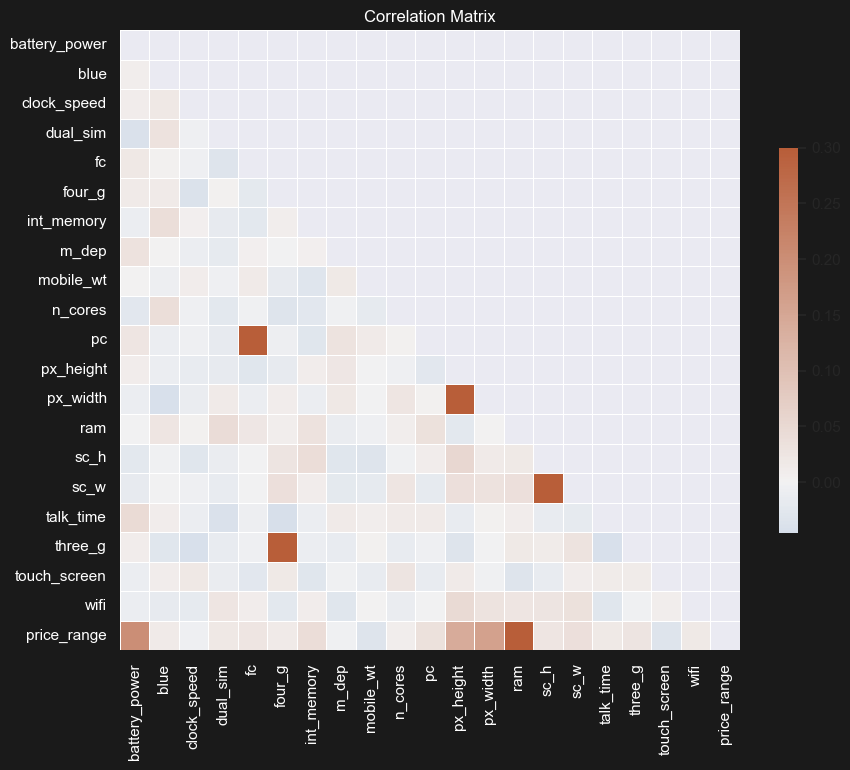

In [391]:
# Create a correlation matrix
corr_matrix = df.corr()

# Set the figure size
plt.figure(figsize=(10, 10), facecolor='k')

# Set the style of the plot
sns.set_theme(style="dark")

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(250, 25, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
ax = sns.heatmap(corr_matrix, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

# Set the color of the labels to white and bring them to the front
ax.tick_params(colors='white', axis='y', labelrotation=0)
ax.tick_params(colors='white', axis='x', labelrotation=90)

# Set the title and its color
plt.title('Correlation Matrix', color='white')

plt.show()

We notice that there is a strong relation between these features: </br>
`pc` and `fc`</br>
`px_height` and `px_width`</br>
`sc_w` and `sc_h`</br></br>
So one feature of each relation is enough, So we will delete  `fc` and `px_width` and `sc_h` </br></br>
Although there is a strong relation between `ram` and `price_range`, we cannot delete one of them because the `price_range` is the target, so the `ram` is very important feature

In [392]:
# Drop the 'pc', 'px_width', and 'sc_h' columns
df = df.drop(['pc', 'px_width', 'sc_h'], axis=1)

# Check the remaining columns
print(df.columns)

Index(['battery_power', 'blue', 'clock_speed', 'dual_sim', 'fc', 'four_g',
       'int_memory', 'm_dep', 'mobile_wt', 'n_cores', 'px_height', 'ram',
       'sc_w', 'talk_time', 'three_g', 'touch_screen', 'wifi', 'price_range'],
      dtype='object')


### Separate the features and the target variable

In [393]:
X = df.iloc[:, :-1].values
y = df.iloc[:, -1].values

### Split data into a training set and a test set

In [394]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
print(X_train.shape)

(1576, 17)


### Normalize data </br>
(We commented that beacause we add it to the pipline)

In [395]:
# sc = StandardScaler()
# X_train = sc.fit_transform(X_train)
# X_test = sc.transform(X_test)

# We commented that beacause we add it to the pipline

## Model Training Evaluation

In [396]:
# Define pipelines for each classifier
pipe_rf = Pipeline([('scaler', StandardScaler()), ('rf', RandomForestClassifier())])
pipe_lr = Pipeline([('scaler', StandardScaler()), ('lr', LogisticRegression(solver='liblinear'))])
pipe_svc = Pipeline([('scaler', StandardScaler()), ('svc', SVC())])

# Set up the parameter grids
param_grid_rf = {
    'rf__n_estimators': [10, 50, 100],
    'rf__criterion': ['gini', 'entropy']
}

param_grid_lr = {
    'lr__C': [0.1, 1, 10],
    'lr__penalty': ['l1', 'l2']
}

param_grid_svc = {
    'svc__C': [0.1, 1, 10],
    'svc__kernel': ['linear', 'rbf']
}

# Combine the pipelines and parameter grids
pipelines = [pipe_rf, pipe_lr, pipe_svc]
param_grids = [param_grid_rf, param_grid_lr, param_grid_svc]
pipe_names = ['Random Forest', 'Logistic Regression', 'SVC']

# Apply Grid Search with Cross Validation for each pipeline
for pipe, param_grid, name in zip(pipelines, param_grids, pipe_names):
    grid = GridSearchCV(pipe, param_grid, cv=5, error_score='raise')
    grid.fit(X_train, y_train)
    print(f"Best parameters for {name}: ", grid.best_params_)
    print(f"Training set score with best parameters for {name}: {grid.score(X_train, y_train)}") 
    print(f"Test set score with best parameters for {name}: {grid.score(X_test, y_test)}")
    print('\n')
    
    model = grid.best_estimator_
    # fit the model on X_train and y_train
    model.fit(X_train, y_train).predict(X_test)
    # predcit using X_test
    y_pred = model.predict(X_test)
    
    # classification reprot
    report = classification_report(y_test, y_pred)
    print(report)
    

Best parameters for Random Forest:  {'rf__criterion': 'gini', 'rf__n_estimators': 100}
Training set score with best parameters for Random Forest: 1.0
Test set score with best parameters for Random Forest: 0.8556962025316456


              precision    recall  f1-score   support

           0       0.91      0.90      0.90        99
           1       0.82      0.76      0.79       102
           2       0.78      0.84      0.81        87
           3       0.94      0.94      0.94       107

    accuracy                           0.86       395
   macro avg       0.86      0.86      0.86       395
weighted avg       0.86      0.86      0.86       395

Best parameters for Logistic Regression:  {'lr__C': 1, 'lr__penalty': 'l1'}
Training set score with best parameters for Logistic Regression: 0.8388324873096447
Test set score with best parameters for Logistic Regression: 0.8481012658227848


              precision    recall  f1-score   support

           0       0.94      0.98      0.9

Based on the results, the `Support Vector Classifier (SVC)` appears to be the best model. Here’s why:

● It has the highest test set accuracy score of `0.924`, which means it correctly predicted the price range for about `92.4%` of the devices in the test set. </br>
● The `precision`, `recall`, and `f1-score` for each class are also high, indicating good performance across all classes. </br>
● The training set score is `0.921`, which is slightly lower than the test set score. This is a good sign because it means the model is not overfitting to the training data.

Show Evaluation for selected model

In [397]:
def trainAndEval(model, X_train, X_test, y_train, y_test):
    
    # fit the model on X_train and y_train
    model.fit(X_train, y_train)
    # predict using X_test
    y_pred = model.predict(X_test)

    # calculate the accuracy_score
    accuracy = accuracy_score(y_test, y_pred)
    # calculate the f1 score
    f1 = f1_score(y_test, y_pred, average='micro')

    print("Accuracy is ", accuracy)
    print('F1 score is', f1)
    
    # confusion_matrix
    confusion = confusion_matrix(y_test, y_pred)

    # Create a figure with three subplots
    fig = plt.figure(figsize=(30, 30))

    # Add subplots
    ax1 = fig.add_subplot(2, 2, 1)
    ax2 = fig.add_subplot(2, 2, 2)
    ax3 = fig.add_subplot(2, 2, (3, 5))

    # Plot the confusion matrix on the second row
    df_cm = pd.DataFrame(confusion, index = ['low cost', 'medium cost', 'high cost', 'very high cost'], 
                         columns = ['low cost', 'medium cost', 'high cost', 'very high cost'])
    sns.heatmap(df_cm, annot=True, ax=ax3)
    ax3.set_title('Confusion Matrix')
    ax3.set_ylabel('True label')
    ax3.set_xlabel('Predicted label')

    # classification report
    report = classification_report(y_test, y_pred)
    print(report)

    # Binarize the output
    y_test_bin = label_binarize(y_test, classes=[0, 1, 2, 3])
    y_score_bin = model.decision_function(X_test)

    # precision_recall curve
    precision = dict()
    recall = dict()

    class_names = ['low cost', 'medium cost', 'high cost', 'very high cost']

    for i in range(4):
        precision[i], recall[i], _ = precision_recall_curve(y_test_bin[:, i], y_score_bin[:, i])
        ax1.plot(recall[i], precision[i], lw=2, label=class_names[i])

    ax1.set_xlabel("recall")
    ax1.set_ylabel("precision")
    ax1.legend(loc="best")
    ax1.set_title("Precision vs. Recall Curve")

    # ROC curve
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    for i in range(4):
        fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score_bin[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
        ax2.plot(fpr[i], tpr[i], lw=2, label='ROC curve of class {0} (area = {1:0.2f})'.format(class_names[i], roc_auc[i]))

    ax2.plot([0, 1], [0, 1], 'k--', lw=2)
    ax2.set_xlim([0.0, 1.0])
    ax2.set_ylim([0.0, 1.05])
    ax2.set_xlabel('False Positive Rate')
    ax2.set_ylabel('True Positive Rate')
    ax2.set_title('Receiver Operating Characteristic')
    ax2.legend(loc="lower right")

    # Show the plots
    plt.tight_layout()
    plt.show()

Accuracy is  0.9189873417721519
F1 score is 0.9189873417721519
              precision    recall  f1-score   support

           0       0.95      0.94      0.94        99
           1       0.91      0.87      0.89       102
           2       0.88      0.89      0.88        87
           3       0.94      0.97      0.95       107

    accuracy                           0.92       395
   macro avg       0.92      0.92      0.92       395
weighted avg       0.92      0.92      0.92       395



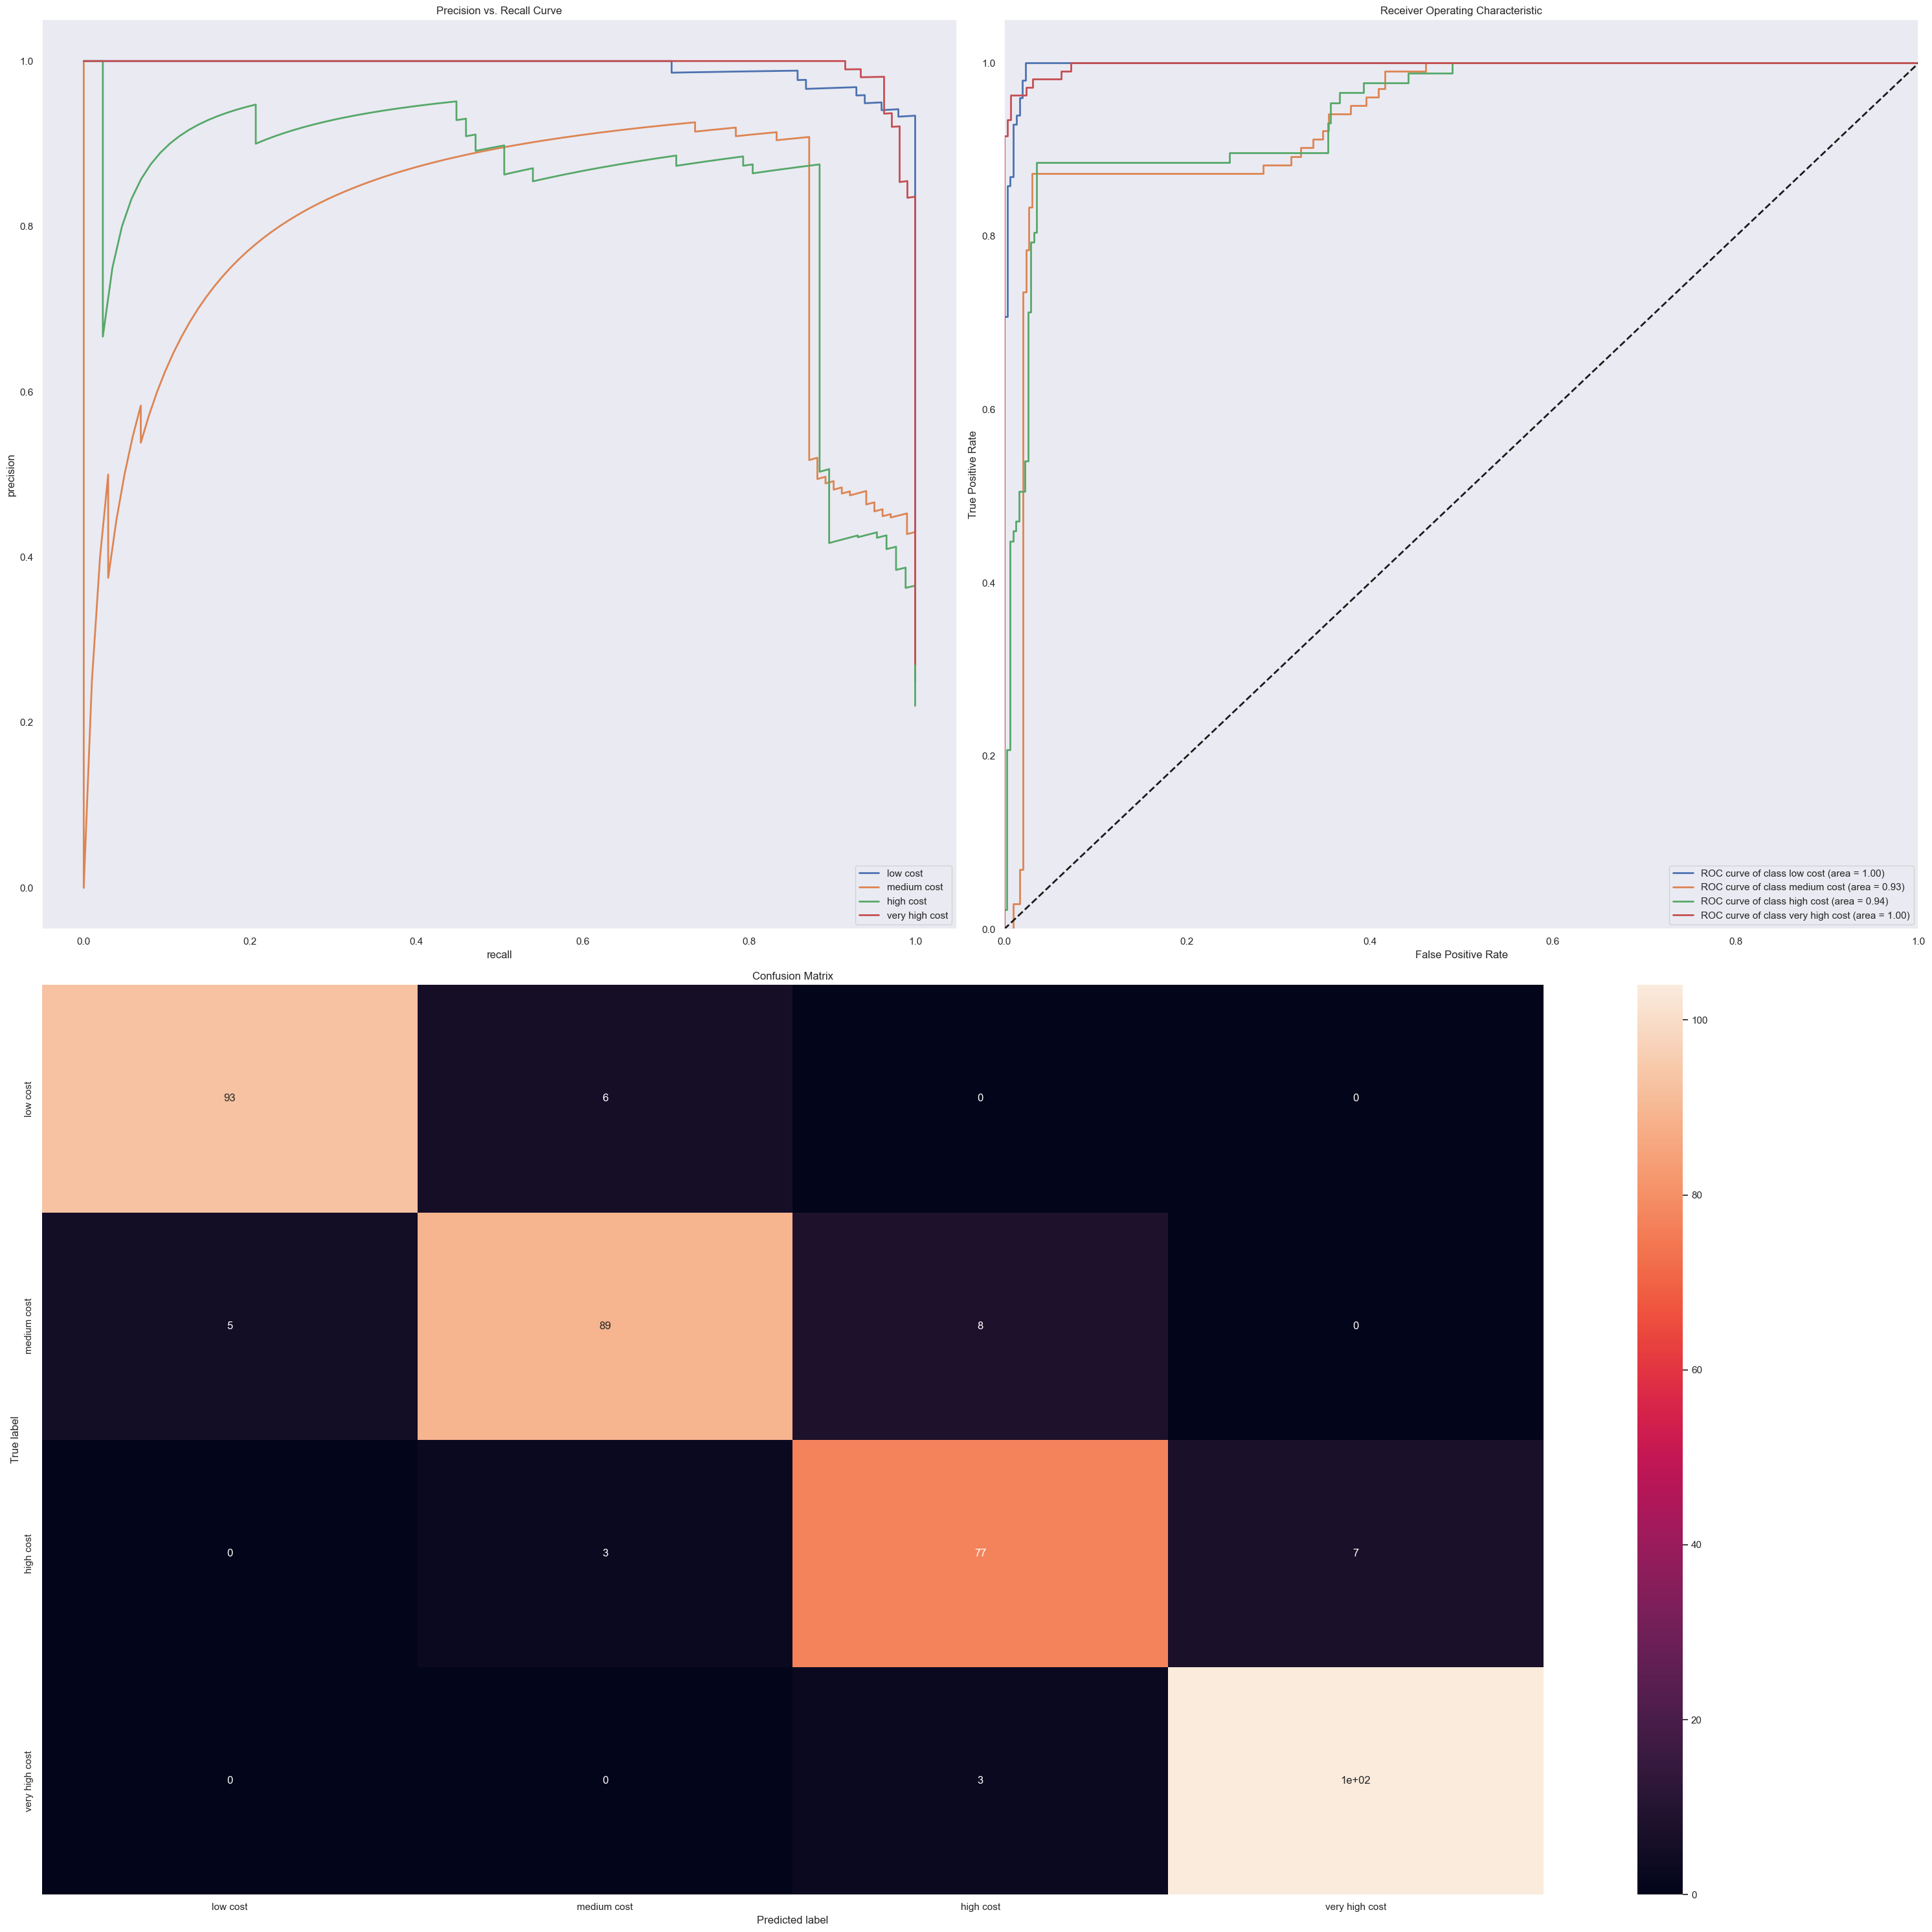

In [398]:
svc_model = Pipeline([('scaler', StandardScaler()), ('svc', SVC(C=1, kernel='linear'))])
trainAndEval(svc_model, X_train, X_test, y_train, y_test)

### Save model

In [399]:
joblib.dump(svc_model, 'model.pkl')
print("Model dumped!")

Model dumped!
